In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"divyansh6349","key":"5b6c93d20647e068496a89b905b87753"}'}

In [13]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!pip install kaggle
!kaggle datasets download -d ejlok1/cremad
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

 96% 435M/451M [00:06<00:00, 79.8MB/s]
100% 451M/451M [00:06<00:00, 73.9MB/s]
 96% 409M/428M [00:03<00:00, 120MB/s]
100% 428M/428M [00:03<00:00, 113MB/s]
 99% 424M/429M [00:04<00:00, 125MB/s] 
100% 429M/429M [00:04<00:00, 110MB/s]
 76% 82.0M/107M [00:01<00:00, 78.5MB/s]
100% 107M/107M [00:01<00:00, 90.1MB/s] 


In [15]:
!unzip cremad.zip
!unzip toronto-emotional-speech-set-tess.zip
!unzip surrey-audiovisual-expressed-emotion-savee.zip
!unzip ravdess-emotional-speech-audio.zip

Streaming output truncated to the last 5000 lines.
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_such_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_sure_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_take_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_talk_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_tape_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_team_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_happy/OAF_tell_happy.wav  
  inflating: tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_

In [16]:
import pandas as pd
import numpy as np
!pip install librosa
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [20]:
Ravdess = "audio_speech_actors_01-24/"

In [21]:
Crema = "AudioWAV/"
Tess = "TESS Toronto emotional speech set data/"
Savee = "ALL/"

In [22]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,sad,audio_speech_actors_01-24/Actor_03/03-01-04-02...
1,sad,audio_speech_actors_01-24/Actor_03/03-01-04-02...
2,disgust,audio_speech_actors_01-24/Actor_03/03-01-07-01...
3,disgust,audio_speech_actors_01-24/Actor_03/03-01-07-02...
4,happy,audio_speech_actors_01-24/Actor_03/03-01-03-01...


In [23]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,AudioWAV/1051_ITS_ANG_XX.wav
1,happy,AudioWAV/1022_IEO_HAP_HI.wav
2,happy,AudioWAV/1070_TAI_HAP_XX.wav
3,fear,AudioWAV/1084_ITS_FEA_XX.wav
4,fear,AudioWAV/1051_TSI_FEA_XX.wav


In [24]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,angry,TESS Toronto emotional speech set data/OAF_ang...
1,angry,TESS Toronto emotional speech set data/OAF_ang...
2,angry,TESS Toronto emotional speech set data/OAF_ang...
3,angry,TESS Toronto emotional speech set data/OAF_ang...
4,angry,TESS Toronto emotional speech set data/OAF_ang...


In [25]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,happy,ALL/JE_h09.wav
1,happy,ALL/KL_h12.wav
2,happy,ALL/KL_h10.wav
3,surprise,ALL/DC_su04.wav
4,neutral,ALL/JK_n24.wav


In [26]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,sad,audio_speech_actors_01-24/Actor_03/03-01-04-02...
1,sad,audio_speech_actors_01-24/Actor_03/03-01-04-02...
2,disgust,audio_speech_actors_01-24/Actor_03/03-01-07-01...
3,disgust,audio_speech_actors_01-24/Actor_03/03-01-07-02...
4,happy,audio_speech_actors_01-24/Actor_03/03-01-03-01...


In [27]:
print(data_path.Emotions.dtype)

object


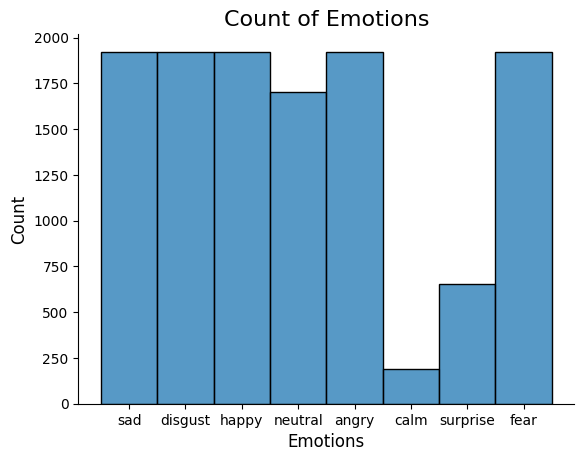

In [28]:
plt.title('Count of Emotions', size=16)
sns.histplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [29]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

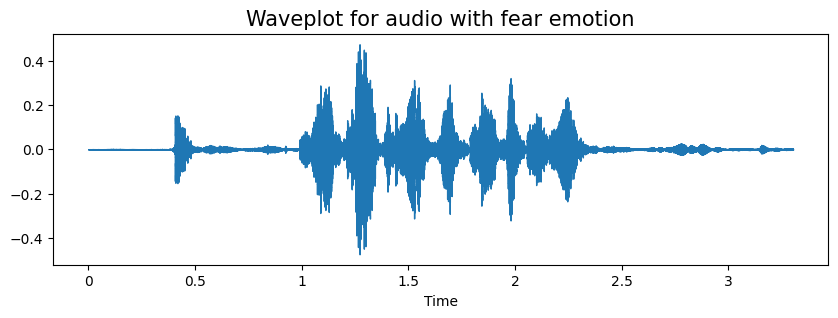

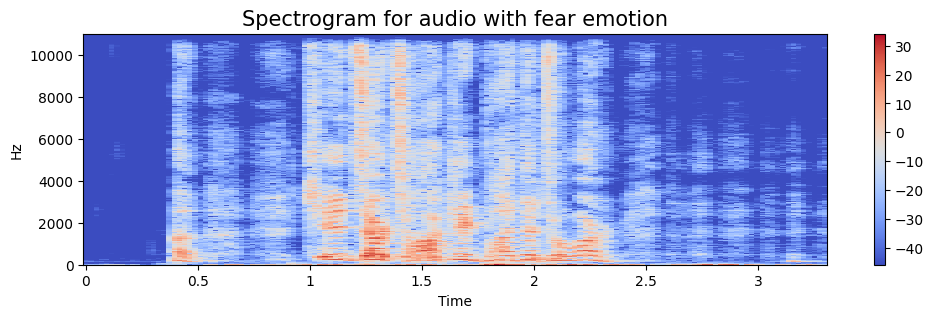

In [30]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [31]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate,n_steps = 1)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

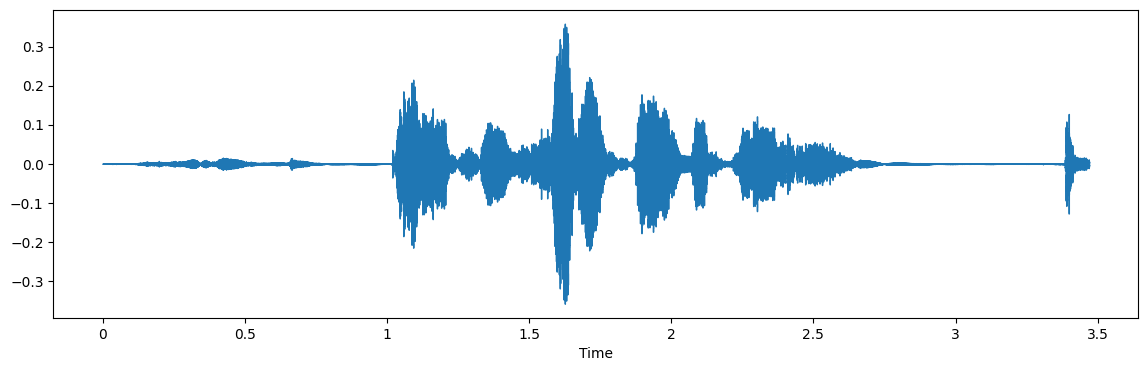

In [32]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

In [33]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [34]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    rate = 0.8
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [37]:
X, Y = [], []
from tqdm import tqdm
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions),total=len(data_path)):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

 52%|█████▏    | 6272/12162 [24:49<23:42,  4.14it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 12162/12162 [45:31<00:00,  4.45it/s]


In [38]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.162643,0.514500,0.579890,0.625069,0.642072,0.621186,0.612664,0.615927,0.620034,0.605733,...,0.000213,0.000222,0.000281,0.000214,0.000191,0.000301,0.000218,0.000114,0.000011,sad
1,0.254756,0.608812,0.626545,0.675248,0.720307,0.704101,0.670452,0.634073,0.670308,0.669074,...,0.000790,0.000818,0.000896,0.000782,0.000763,0.000872,0.000786,0.000666,0.000582,sad
2,0.126345,0.508279,0.489384,0.539289,0.605388,0.594149,0.608083,0.622892,0.596790,0.617130,...,0.000032,0.000042,0.000044,0.000049,0.000055,0.000047,0.000042,0.000034,0.000003,sad
3,0.093863,0.479113,0.512153,0.518702,0.540317,0.577788,0.610496,0.660936,0.668187,0.646289,...,0.001811,0.002862,0.002039,0.001271,0.001297,0.001492,0.002048,0.001319,0.000110,sad
4,0.297558,0.667024,0.698445,0.698840,0.705748,0.691148,0.684071,0.727542,0.738527,0.719846,...,0.004883,0.006195,0.005307,0.004475,0.004440,0.004602,0.005280,0.004544,0.003340,sad


In [39]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [40]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [41]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [42]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=8, activation='softmax'))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1024      
                                                                 
 batch_normalization (Batch  (None, 162, 256)          1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 162, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           196864    
                                                                 
 batch_normalization_1 (Bat  (None, 81, 256)           1

In [44]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 20s 18ms/step - loss: 1.6403 - accuracy: 0.3423 - val_loss: 1.9727 - val_accuracy: 0.2755 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 6s 14ms/step - loss: 1.4179 - accuracy: 0.4353 - val_loss: 1.3218 - val_accuracy: 0.4642 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 6s 15ms/step - loss: 1.3409 - accuracy: 0.4656 - val_loss: 1.2345 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 6s 14ms/step - loss: 1.2779 - accuracy: 0.4913 - val_loss: 1.2621 - val_accuracy: 0.4980 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 6s 15ms/step - loss: 1.2477 - accuracy: 0.5029 - val_loss: 1.1861 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 6s 14ms/step - loss: 1.2150 - accuracy: 0.5124 - val_loss: 1.2337 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 9s 22ms/s

286/286 [==============================] - 2s 6ms/step - loss: 1.0086 - accuracy: 0.6086
Accuracy of our model on test data :  60.86384654045105 %


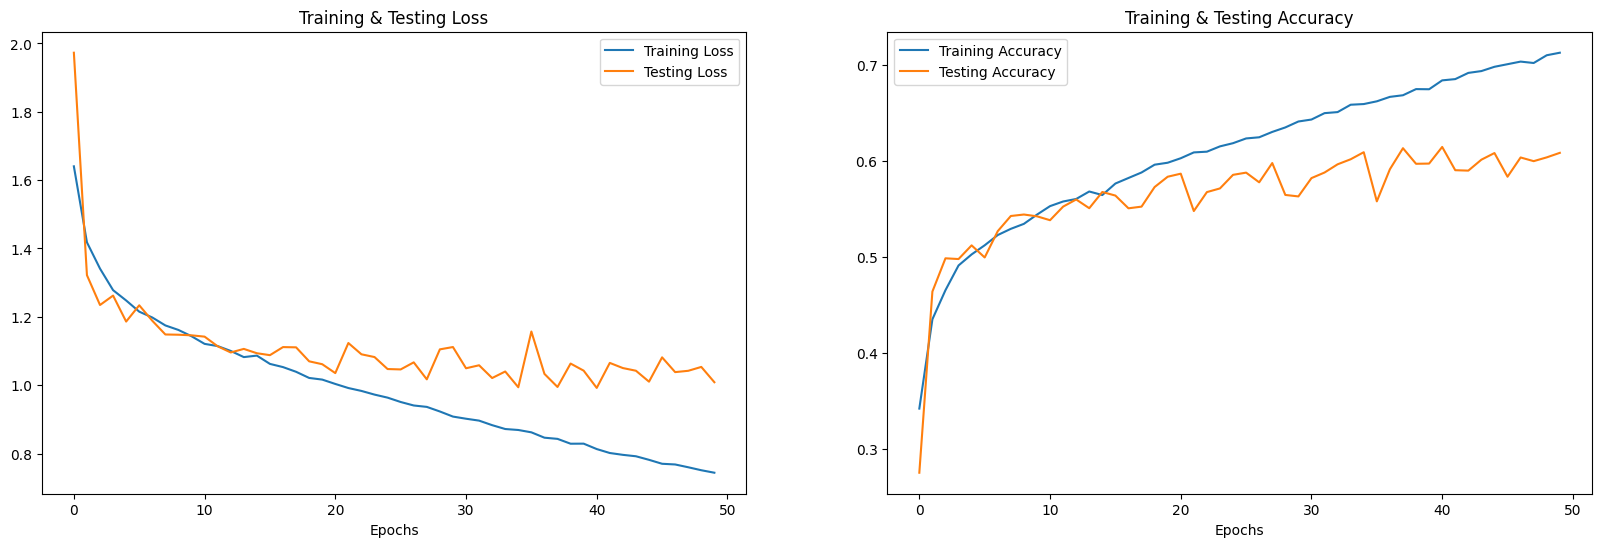

In [45]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [46]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 2s 5ms/step


In [47]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,surprise,surprise
2,happy,angry
3,sad,neutral
4,neutral,neutral
5,fear,fear
6,surprise,disgust
7,disgust,disgust
8,fear,disgust
9,neutral,disgust


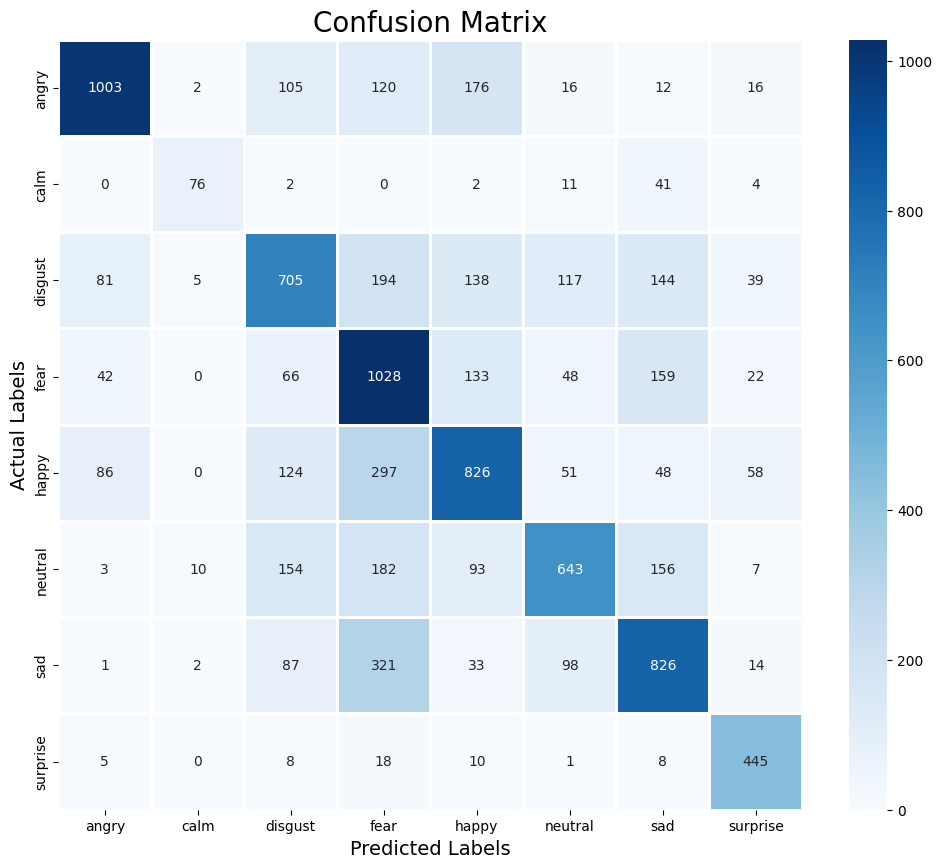

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.82      0.69      0.75      1450
        calm       0.80      0.56      0.66       136
     disgust       0.56      0.50      0.53      1423
        fear       0.48      0.69      0.56      1498
       happy       0.59      0.55      0.57      1490
     neutral       0.65      0.52      0.58      1248
         sad       0.59      0.60      0.60      1382
    surprise       0.74      0.90      0.81       495

    accuracy                           0.61      9122
   macro avg       0.65      0.62      0.63      9122
weighted avg       0.62      0.61      0.61      9122



In [52]:
import os

models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_version = max([int(i) for i in os.listdir(models_dir) + [0]]) + 1
model.save(f"{models_dir}/{model_version}")


In [54]:
from google.colab import drive
drive.mount('/content/drive')

# Then save your model in the mounted Google Drive
model.save(f"/content/drive/My Drive/models/{model_version}")


Mounted at /content/drive
